In [22]:
import os
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'
os.chdir(base_dir) 
from core import expression_plots 
from core import io_library 
# from IPython.core.debugger import Tracer
import numpy as np
import pandas as pd
# import re
import matplotlib.pyplot as plt 
import seaborn as sns
# import csv
import scipy.cluster.hierarchy as sch
from collections import Counter, defaultdict
# import math
# import plotly.plotly as py
# py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
# Learn about API authentication here: https://plot.ly/pandas/getting-started
# Find your api_key here: https://plot.ly/settings/api

#from sklearn.cluster import AgglomerativeClustering

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Plot KL LFC alongside KL Expression data from regev. 

In [3]:

# Load KL DE Seq Data
kl_nmpp1_lfc = pd.read_pickle(base_dir + "\expression_data\kl_PKA_as_20160824\LFC_KLac_ASmin_ASplus.pkl")
# drop padj (not used for this analysis)
kl_nmpp1_lfc.drop('padj',axis=1, inplace=True) 



In [16]:
#Reload KL microarry data from Regev lab. 

#had to update growth data file after noticing an error
#only need to do this once
species_list = ['Kluyveromyces lactis', 'Saccharomyces cerevisiae']
fname_out_bases = ['KLac', 'SCer']
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'

io_library.make_data_tables(species_list,fname_out_bases, base_dir)

C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\KLac_raw_exp.csv saved


core\io_library.py:200: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  expdata = expdata.sort()


All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv saved
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\SCer_raw_exp.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv sav

In [4]:
#Reload KL microarry data from Regev lab. cont
#Import KL ESR data

# This is the regev raw expression
#   1) It might be interesting to plot it v.s. the RNA seq level data (but counts is not gene expression)
#   2) It would be good to integrate the data into the big dataframe
# #Load raw expression data
# species = 'KLac'
# fname = os.path.normpath(base_dir + "\expression_data\\raw_exp\\"  + species + '_raw_exp.csv')
# raw_exp = pd.read_csv(fname, index_col = 'orf_name')
# print fname + ' raw expression dataset loaded'
# #extract mean expression only
# mean_gene_expression = raw_exp['Mean']
# mean_gene_expression.name = 'mean_gene_expression'

#Load data for microarrays
species = 'KLac'

fname = os.path.normpath(base_dir + "\expression_data\\GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' growth microarray dataset loaded'

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + "\expression_data\\GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' stress microarray dataset loaded'

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print "Error: ID mismatch between condition data. Species = {}".format(species)
condition_arrays = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays.reset_index(level=0, inplace=True)

C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv growth microarray dataset loaded
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv stress microarray dataset loaded


In [5]:
#Join Regev data to Log fold change from KL PKA inhibition experiment

kl_stress_nmpp1_data = kl_nmpp1_lfc.join(condition_arrays, on = 'orf_name') 
kl_stress_nmpp1_data.drop('ID', axis=1, inplace=True)
kl_stress_nmpp1_data.set_index('orf_name',inplace = True)

[6, 7, 0, 10, 11, 12, 13, 14, 3, 4, 1, 5, 15, 18, 16, 17, 2, 8, 9]
[0, 3, 4, 1, 5, 11, 12, 13, 14, 6, 7, 18, 17, 16, 15, 8, 9, 2]


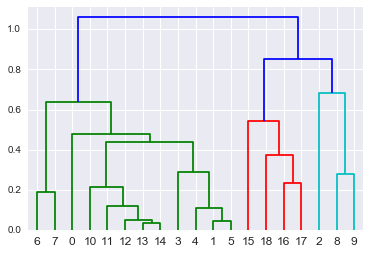

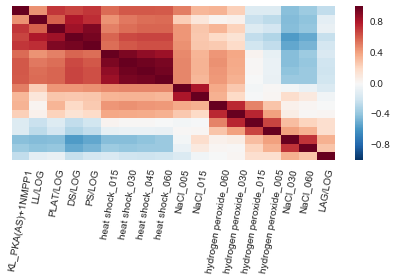

In [19]:
#Correlation heatmap with all conditions v.s. PKA inhibition. 

#First do heirarchical clustering of conditions, then reorder matrix. 
kl_stress_nmpp1_data_nanrm = kl_stress_nmpp1_data.fillna(0.0)
kl_stress_nmpp1_data_transpose = kl_stress_nmpp1_data_nanrm.as_matrix().transpose()
col_cluster = sch.linkage(kl_stress_nmpp1_data_transpose, method='average', metric = 'correlation')
col_dend = sch.dendrogram(col_cluster)
col_ind_reorder = col_dend['leaves']
#new columns look almost right but need to flip the tree around.  
print col_ind_reorder
col_ind_reorder_pretty = [0,3,4,1,5,11,12,13,14,6,7,18,17,16,15,8,9,2]
print col_ind_reorder_pretty

# col_ind_reorder_branch_flip ={16 : 19, 19: 18, 18:16}
# col_ind_reorder_pretty = col_ind_reorder[:]  #Need to use slice because otherwise the two lists are linked.  This makes a copy
# for key in col_ind_reorder_branch_flip.keys():
#     ind_ind = col_ind_reorder.index(key)
#     col_ind_reorder_pretty[ind_ind] = col_ind_reorder_branch_flip[key]

old_cols = kl_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]



kl_stress_nmpp1_data_col_reorder = kl_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
#corr = kl_stress_nmpp1_data.corr()
corr = kl_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_corr.png')
#Clean up labels


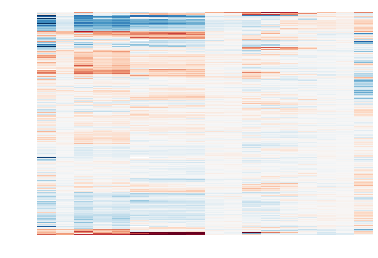

In [26]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes. 

#First filter out items with mostly NA values. 
kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))

#Drop out PKA column for clustering
kl_stress_data = kl_stress_nmpp1_data_filt.drop('KL_PKA(AS)+1NMPP1', axis = 1)

kl_stress_data_nafill = kl_stress_data.fillna(0.0)
kl_stress_data_mat = kl_stress_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

row_cluster = sch.linkage(kl_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = kl_stress_nmpp1_data_filt.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

kl_stress_nmpp1_data_filt_reorder = kl_stress_nmpp1_data_filt.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-kl_stress_nmpp1_data_filt_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')


In [ ]:
#SC PKA inhibition data alongside SC Expression data from regev ordering the columns as determined by KL clustering above. 

In [12]:
#Load oshea PKA inhibition data

oshea_SC_PKA_data = io_library.load_oshea_NMPP1_data()


In [14]:
#Import Regev data for SCer
#Load data for microarrays
species = 'SCer'

fname = os.path.normpath(base_dir + "\expression_data\\GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' growth microarray dataset loaded'

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + "\expression_data\\GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' stress microarray dataset loaded'

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print "Error: ID mismatch between condition data. Species = {}".format(species)
condition_arrays_SC = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays_SC.reset_index(level=0, inplace=True)


C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv growth microarray dataset loaded
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv stress microarray dataset loaded


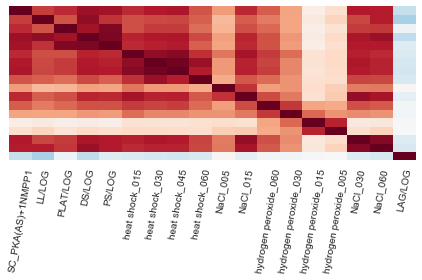

In [20]:
#Using same condition ordering as in KL dataset, look at SCer condition clustering. 

#Merge NMPP1 and Condition Data
sc_stress_nmpp1_data = pd.merge(oshea_SC_PKA_data, condition_arrays_SC, how='inner', left_index=True, right_index=True)
sc_stress_nmpp1_data.drop(['ID', 'SC_common_name'], axis=1, inplace=True)

#Reorder columns 
old_cols = sc_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]

sc_stress_nmpp1_data_col_reorder = sc_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
corr = sc_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr, cbar = False)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_corr.png')


In [23]:
#Cleans up SC NMPP1/Stress data to cluster genes

#Filter out columns that have mostly NA values. 
sc_stress_nmpp1_data_filt = sc_stress_nmpp1_data_col_reorder.dropna(thresh=(len(sc_stress_nmpp1_data_col_reorder.columns)-1))

#Combine rows that have duplicate values. 
gene_names = sc_stress_nmpp1_data_filt.index.tolist()
print len(gene_names)
print len(set(gene_names))

#This shows you which genes have duplicates 
# frequency = Counter(gene_names)
# frequency.most_common()[:20]

#Builds a dictionary that gives index values in the original dataframe for each genename 
gene_names_to_inds = defaultdict(list)
for ind, value in enumerate(gene_names):
    gene_names_to_inds[value].append(ind)

# gene_names_to_inds['YNR077C']

# #Build new dataframe, averaging duplicate indices
sc_stress_nmpp1_data_consolidated_list = []
col_names = sc_stress_nmpp1_data_filt.columns
Ncols = len(col_names)
for gene_name, inds in gene_names_to_inds.iteritems():
    if len(inds) == 1:
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,sc_stress_nmpp1_data_filt.iloc[inds[0],:]))
    else: 
        exp_values_no_zeros = []
        repeat_data = sc_stress_nmpp1_data_filt.iloc[inds]
        for col_name in col_names:
            exp_values_no_zeros.append([val for val in repeat_data[col_name] if val !=0])

        exp_values_avg = []
        for val in exp_values_no_zeros:
            if len(val)==0:
                exp_values_avg.append(0.0)
            else:
                exp_values_avg.append(np.mean(val))
        
        exp_values_avg_series = pd.Series(exp_values_avg, index =col_names)
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,exp_values_avg_series))

sc_stress_nmpp1_data_consolidated = pd.DataFrame.from_items(sc_stress_nmpp1_data_consolidated_list , orient='index', columns=col_names)


6212
6184


clustering
plotting


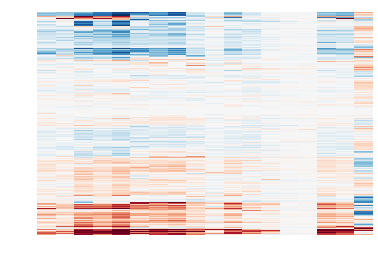

In [25]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes.

#drop out AS data for clustering
sc_stress_data = sc_stress_nmpp1_data_consolidated.drop(['SC_PKA(AS)+1NMPP1'], axis = 1)

sc_stress_data_nafill = sc_stress_data.fillna(0.0)
sc_stress_data_mat = sc_stress_data_nafill.as_matrix()

print 'clustering'
row_cluster = sch.linkage(sc_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = sc_stress_nmpp1_data_consolidated.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

sc_stress_nmpp1_data_reorder = sc_stress_nmpp1_data_consolidated.reindex(new_rows)

print 'plotting'
fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-sc_stress_nmpp1_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_genes.png')
